In [1]:
import os
import cv2
import numpy as np

In [2]:
if not os.path.isdir('up'):
  !git clone https://github.com/joaopauloschuler/PlantDoc-Object-Detection-Dataset.git up

Cloning into 'up'...
remote: Enumerating objects: 5190, done.
remote: Total 5190 (delta 0), reused 0 (delta 0), pack-reused 5190
Receiving objects: 100% (5190/5190), 941.89 MiB | 42.26 MiB/s, done.
Resolving deltas: 100% (2328/2328), done.
Updating files: 100% (5199/5199), done.


In [3]:
up_data_dir = os.getcwd()+"/up/TRAIN"
up_test_dir = os.getcwd()+"/up/TEST"
data_dir = "cropped_train/"
test_dir = "cropped_test/"
all_dir = "cropped_all/"

In [4]:
def CropImages(orig_data_dir, dest_data_dir, csv_file, include_original=False, verbose=True, prefix='img_'):
  # Load the CSV file.
  with open (csv_file, "r") as myfile:
    csv_lines=myfile.readlines()

  # Transform the CSV file into an array  
  line_count = 0
  a_lines = []
  for str_line in csv_lines:
    if line_count > 0: 
      a_line = str_line.replace('\n', '').split(',')
      a_lines.append(a_line)
    line_count = line_count + 1
  #a_lines = np.array(a_lines, dtype=object)
  
  # create destination folder
  if not os.path.isdir(dest_data_dir):
    os.mkdir(dest_data_dir)

  # Save cropped images
  line_count = 0
  failed_count = 0
  original_count = 0
  last_image_file = ''
  for a_line in a_lines:
    dest_folder_name = dest_data_dir+'/'+a_line[3]
    dest_file_name = dest_folder_name+'/'+prefix+str(line_count)+'.jpg'
    orig_file_name = orig_data_dir+'/'+ a_line[0]
    print(line_count,':', a_line, dest_file_name)
    if last_image_file != orig_file_name:
      if os.path.isfile(orig_file_name):
        img = cv2.imread(orig_file_name)
        #cv2_imshow(img)
        last_image_file = orig_file_name
        can_load = True
        original_count = original_count + 1
        if verbose: print("Original imgage shape",img.shape)
        if (include_original):
          if not os.path.isdir(dest_folder_name):
            os.mkdir(dest_folder_name)
          cv2.imwrite(dest_folder_name+'/ori_'+prefix+str(original_count)+'.jpg',img)  
      else:
        if verbose: print('File does not exist:', orig_file_name)
        can_load = False
        #break
    if (can_load):
      y1 = int(a_line[4])
      x1 = int(a_line[5])
      y2 = int(a_line[6])
      x2 = int(a_line[7])

      x_min = np.min([x1, x2])
      x_max = np.max([x1, x2])
      y_min = np.min([y1, y2])
      y_max = np.max([y1, y2])

      crop_img = img[x_min:x_max, y_min:y_max]
      if verbose: print("Cropped imgage shape",crop_img.shape,':', x_min, x_max, y_min, y_max,' deltas:',x_max - x_min, y_max - y_min)
      if not os.path.isdir(dest_folder_name):
        os.mkdir(dest_folder_name)
      if ( (crop_img.shape[0]==0) or (crop_img.shape[1]==0)):
        failed_count = failed_count + 1
        if verbose: print("Failed cropping.");
      else:
        cv2.imwrite(dest_file_name,crop_img)
    else:
      failed_count = failed_count + 1
    line_count = line_count + 1
  print("Processed files:", line_count, "Failed count: ", failed_count, "Original count:", original_count)

In [ ]:
!rm -rf /kaggle/working/cropped_train

In [5]:
if not os.path.isdir(data_dir):
  CropImages(orig_data_dir=up_data_dir, dest_data_dir=data_dir, csv_file='up/train_labels.csv', include_original=False, prefix='train_')

0 : ['cherry-tree-leaves-and-fruits.jpg', '350', '300', 'Cherry leaf', '198', '77', '299', '252'] cropped_train//Cherry leaf/train_0.jpg
Original imgage shape (300, 350, 3)
Cropped imgage shape (175, 101, 3) : 77 252 198 299  deltas: 175 101
1 : ['cherry-tree-leaves-and-fruits.jpg', '350', '300', 'Cherry leaf', '3', '114', '148', '235'] cropped_train//Cherry leaf/train_1.jpg
Cropped imgage shape (121, 145, 3) : 114 235 3 148  deltas: 121 145
2 : ['cherry-tree-leaves-and-fruits.jpg', '350', '300', 'Cherry leaf', '30', '184', '189', '297'] cropped_train//Cherry leaf/train_2.jpg
Cropped imgage shape (113, 159, 3) : 184 297 30 189  deltas: 113 159
3 : ['cherry-tree-leaves-and-fruits.jpg', '350', '300', 'Cherry leaf', '226', '4', '346', '83'] cropped_train//Cherry leaf/train_3.jpg
Cropped imgage shape (79, 120, 3) : 4 83 226 346  deltas: 79 120
4 : ['peach-and-leaf-stock-image-2809275.jpg', '1300', '1099', 'Peach leaf', '237', '479', '527', '810'] cropped_train//Peach leaf/train_4.jpg
Origi

In [6]:
if not os.path.isdir(test_dir):
  CropImages(orig_data_dir=up_test_dir, dest_data_dir=test_dir, csv_file='up/test_labels.csv', include_original=False, prefix='test_')

0 : ['Black%20rot%20on%20foliage.jpg', '1060', '795', 'grape leaf black rot', '1', '58', '859', '732'] cropped_test//grape leaf black rot/test_0.jpg
Original imgage shape (795, 1060, 3)
Cropped imgage shape (674, 858, 3) : 58 732 1 859  deltas: 674 858
1 : ['pepper_leaf.jpg', '300', '400', 'Bell_pepper leaf', '40', '58', '251', '392'] cropped_test//Bell_pepper leaf/test_1.jpg
Original imgage shape (400, 300, 3)
Cropped imgage shape (334, 211, 3) : 58 392 40 251  deltas: 334 211
2 : ['depositphotos_1323264-Raspberry-leaf-on-white.jpg', '1024', '772', 'Raspberry leaf', '98', '75', '964', '710'] cropped_test//Raspberry leaf/test_2.jpg
Original imgage shape (772, 1024, 3)
Cropped imgage shape (635, 866, 3) : 75 710 98 964  deltas: 635 866
3 : ['dscn6689.jpg', '1024', '768', 'Tomato mold leaf', '140', '102', '887', '712'] cropped_test//Tomato mold leaf/test_3.jpg
Original imgage shape (768, 1024, 3)
Cropped imgage shape (610, 747, 3) : 102 712 140 887  deltas: 610 747
4 : ['IMG_1246.jpg', '

In [7]:
if not os.path.isdir(all_dir):
  !mkdir cropped_all
  ! cp -r cropped_test/* cropped_all/
  ! cp -r cropped_train/* cropped_all/

In [8]:
import os

if not os.path.isdir('k'):
  !git clone https://github.com/joaopauloschuler/k-neural-api.git k
else:
  !git pull

!cd k && pip install .

Cloning into 'k'...
remote: Enumerating objects: 1838, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 1838 (delta 158), reused 171 (delta 88), pack-reused 1588
Receiving objects: 100% (1838/1838), 15.70 MiB | 32.08 MiB/s, done.
Resolving deltas: 100% (1271/1271), done.
Processing /kaggle/working/k
  Preparing metadata (setup.py) ... done
  Created wheel for cai: filename=cai-0.1.7-py3-none-any.whl size=61388 sha256=363fb5e8906720c66de73c57e8bbbbd28bdf1a9bac58d190870ca182423c2cc7
  Stored in directory: /tmp/pip-ephem-wheel-cache-ftpflt_o/wheels/7f/63/1a/ed2b6234f76aae55efe76492246448486e41178bd0b5682ecf
Successfully built cai


In [9]:
from cai import datasets

2024-06-22 05:34:20.768588: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 05:34:20.768694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 05:34:20.910001: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
all_dir = "cropped_all/"

In [11]:
train_x, val_x, test_x, train_y, val_y, test_y, classweight, classes = datasets.load_images_from_folders(seed=7,
  root_dir=all_dir, lab=True, 
  verbose=True, bipolar=False, base_model_name='plant_doc',
  has_training=True, has_validation=True, has_testing=True,
  training_size=0.65, validation_size=0.15, test_size=0.2,
  target_size=(128, 128))

Loading  29  classes.
loading train images
train shape is: (5761, 128, 128, 3)
loading validation images
validation shape is: (1333, 128, 128, 3)
loading test images
test shape is: (1789, 128, 128, 3)
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.07251462  max: 0.9389103
Channel  2  min: 0.033697903  max: 0.96955556
Loaded.


In [12]:
import numpy as np

In [13]:
np.sum(train_y, axis=0)

array([111., 159., 116., 209., 170., 549., 155.,  50., 240.,  82., 403.,
         7., 212., 162., 361., 172., 165., 319., 139., 283., 257., 182.,
       143., 169., 526., 190.,   1., 143.,  86.])

In [14]:
import glob
from pathlib import Path
import numpy as np

In [15]:
train_images = glob.glob('/kaggle/working/cropped_all/**/**')
train_classes = glob.glob('/kaggle/working/cropped_all/*')
print(f'# images: {len(train_images)}')
print(f'# classes: {len(train_classes)}')

# images: 8883
# classes: 29


In [16]:
for class_dir in train_classes:
    class_dir_path = Path(class_dir)
    class_name = class_dir_path.name
    class_images = glob.glob(f'{class_dir}/*')
    print(f'{class_name:<55}: {len(class_images)}')

Blueberry leaf                                         : 845
Tomato Early blight leaf                               : 214
Bell_pepper leaf                                       : 323
Corn rust leaf                                         : 127
grape leaf black rot                                   : 133
Peach leaf                                             : 620
Tomato two spotted spider mites leaf                   : 2
Soyabean leaf                                          : 266
Tomato leaf                                            : 396
Tomato leaf yellow virus                               : 810
Apple Scab Leaf                                        : 171
Potato leaf                                            : 11
Apple rust leaf                                        : 179
Tomato Septoria leaf spot                              : 436
Bell_pepper leaf spot                                  : 263
Tomato mold leaf                                       : 293
Apple leaf                 

In [17]:
import tensorflow as tf
import random
import cv2
import skimage

import matplotlib.pyplot as plt
import numpy as np

In [18]:
class PlantDocGenerator:
    def __init__(self, files_path, labels_to_idx, image_size, shuffle=True, color_space='rgb', split_channel=None):
        self.files_path = files_path
        self.labels_to_idx = labels_to_idx
        self.image_size = image_size
        self.shuffle = shuffle
        self.color_space = color_space
        self.split_channel = split_channel
    
    def __call__(self):
        if self.shuffle:
            random.shuffle(self.files_path)
        
        for file_path in self.files_path:
            label_str = Path(file_path).parent.name
            label_idx = self.labels_to_idx[label_str]
            label_oh = tf.one_hot(label_idx, len(self.labels_to_idx))

            image = tf.keras.preprocessing.image.load_img(file_path)
            image_arr = tf.keras.preprocessing.image.img_to_array(image)
            image_arr = tf.image.resize_with_pad(image_arr, self.image_size[0], self.image_size[1])
            image_arr /= 255.

            if self.color_space == 'lab':
                image_arr = tf.py_function(func=skimage.color.rgb2lab, inp=[image_arr], Tout=tf.float32)
                image_arr = (image_arr + [0, 128, 128]) / [100, 255, 255]
                image_arr.set_shape((*self.image_size, 3))
            elif self.color_space != 'rgb':
                raise NotImplementedError

            if self.split_channel:
                first_channel = tf.reshape(image_arr[:, :, 0], (*self.image_size, 1))
                second_channel = tf.reshape(image_arr[:, :, 1], (*self.image_size, 1))
                third_channel = tf.reshape(image_arr[:, :, 2], (*self.image_size, 1))
                
                concat = tf.concat([second_channel, third_channel], 2)

                yield (first_channel, concat), label_oh
            else:
                yield image_arr, label_oh

In [19]:
from collections import defaultdict
import copy
import random
from pathlib import Path

def train_validation_test_split(files_path, train_size=0.7, validation_size=0.2):
    files_path = copy.deepcopy(files_path)
    random.shuffle(files_path)
    
    files_per_class = defaultdict(list)
    for f in files_path:
        label = Path(f).parent.name
        files_per_class[label].append(f)
    
    split_files = defaultdict(list)
    for c, files in files_per_class.items():
        train_count = int(len(files) * train_size)
        validation_count = int(len(files) * validation_size)
        
        split_files['train'] += (files[:train_count])
        split_files['validation'] += (files[train_count:(train_count+validation_count)])
        split_files['test'] += (files[(train_count+validation_count):])
    
    return split_files

In [20]:
files_path = [
    p for p in glob.glob('/kaggle/working/cropped_all/**/**')
    if Path(p).parent.name != 'Tomato two spotted spider mites leaf'
]
len(files_path)

8881

In [21]:
split_files = train_validation_test_split(files_path, train_size=0.65, validation_size=0.15)
classes = set([Path(f).parent.name for f in files_path])
labels_to_idx = {c: i for i, c in enumerate(classes)}

output_signature = ((tf.TensorSpec(shape = (None, None, 1), dtype = tf.float32), tf.TensorSpec(shape = (None, None, 2), dtype = tf.float32)),
                    tf.TensorSpec(shape = (len(labels_to_idx)), dtype = tf.int16))

train = tf.data.Dataset.from_generator(
    PlantDocGenerator(split_files['train'], labels_to_idx, (128, 128), color_space='lab', split_channel=True),
    output_signature=output_signature
)
validation = tf.data.Dataset.from_generator(
    PlantDocGenerator(split_files['validation'], labels_to_idx, (128, 128), color_space='lab', split_channel=True),
    output_signature=output_signature
)
test = tf.data.Dataset.from_generator(
    PlantDocGenerator(split_files['test'], labels_to_idx, (128, 128), color_space='lab', split_channel=True),
    output_signature=output_signature
)

In [22]:
img,label = next(iter(test))
print(img[0].shape)
print(img[1].shape)
print(label.shape)

(128, 128, 1)
(128, 128, 2)
(28,)


In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation = validation.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test = test.shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [24]:
batched_train = train.batch(32)
batched_validation = validation.batch(32)
batched_test = test.batch(32)

In [25]:
DEFAULT_BLOCKS_ARGS = {
    "efficientnetv2-s": [
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 24,
            "output_filters": 24,
            "expand_ratio": 1,
            "se_ratio": 0.0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 4,
            "input_filters": 24,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0.0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "conv_type": 1,
            "expand_ratio": 4,
            "input_filters": 48,
            "kernel_size": 3,
            "num_repeat": 4,
            "output_filters": 64,
            "se_ratio": 0,
            "strides": 2,
        },
        {
            "conv_type": 0,
            "expand_ratio": 4,
            "input_filters": 64,
            "kernel_size": 3,
            "num_repeat": 6,
            "output_filters": 128,
            "se_ratio": 0.25,
            "strides": 2,
        },
        {
            "conv_type": 0,
            "expand_ratio": 6,
            "input_filters": 128,
            "kernel_size": 3,
            "num_repeat": 9,
            "output_filters": 160,
            "se_ratio": 0.25,
            "strides": 1,
        },
        {
            "conv_type": 0,
            "expand_ratio": 6,
            "input_filters": 160,
            "kernel_size": 3,
            "num_repeat": 15,
            "output_filters": 256,
            "se_ratio": 0.25,
            "strides": 2,
        },
    ],
    "efficientnetv2-m": [
        {
            "kernel_size": 3,
            "num_repeat": 3,
            "input_filters": 24,
            "output_filters": 24,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 24,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 48,
            "output_filters": 80,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 7,
            "input_filters": 80,
            "output_filters": 160,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 14,
            "input_filters": 160,
            "output_filters": 176,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 18,
            "input_filters": 176,
            "output_filters": 304,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 304,
            "output_filters": 512,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
    ],
    "efficientnetv2-l": [
        {
            "kernel_size": 3,
            "num_repeat": 4,
            "input_filters": 32,
            "output_filters": 32,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 7,
            "input_filters": 32,
            "output_filters": 64,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 7,
            "input_filters": 64,
            "output_filters": 96,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 10,
            "input_filters": 96,
            "output_filters": 192,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 19,
            "input_filters": 192,
            "output_filters": 224,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 25,
            "input_filters": 224,
            "output_filters": 384,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 7,
            "input_filters": 384,
            "output_filters": 640,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
    ],
    "efficientnetv2-b0": [
        {
            "kernel_size": 3,
            "num_repeat": 1,
            "input_filters": 32,
            "output_filters": 16,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 16,
            "output_filters": 32,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 32,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 3,
            "input_filters": 48,
            "output_filters": 96,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 96,
            "output_filters": 112,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 8,
            "input_filters": 112,
            "output_filters": 192,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
    ],
    "efficientnetv2-b1": [
        {
            "kernel_size": 3,
            "num_repeat": 1,
            "input_filters": 32,
            "output_filters": 16,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 16,
            "output_filters": 32,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 32,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 3,
            "input_filters": 48,
            "output_filters": 96,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 96,
            "output_filters": 112,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 8,
            "input_filters": 112,
            "output_filters": 192,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
    ],
    "efficientnetv2-b2": [
        {
            "kernel_size": 3,
            "num_repeat": 1,
            "input_filters": 32,
            "output_filters": 16,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 16,
            "output_filters": 32,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 32,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 3,
            "input_filters": 48,
            "output_filters": 96,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 96,
            "output_filters": 112,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 8,
            "input_filters": 112,
            "output_filters": 192,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
    ],
    "efficientnetv2-b3": [
        {
            "kernel_size": 3,
            "num_repeat": 1,
            "input_filters": 32,
            "output_filters": 16,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 16,
            "output_filters": 32,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 32,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 3,
            "input_filters": 48,
            "output_filters": 96,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 96,
            "output_filters": 112,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 8,
            "input_filters": 112,
            "output_filters": 192,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
    ],
}

CONV_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {
        "scale": 2.0,
        "mode": "fan_out",
        "distribution": "truncated_normal",
    },
}

DENSE_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {
        "scale": 1.0 / 3.0,
        "mode": "fan_out",
        "distribution": "uniform",
    },
}

In [26]:
import math

def round_filters(filters, width_coefficient, min_depth, depth_divisor):
    """Round number of filters based on depth multiplier."""
    filters *= width_coefficient
    minimum_depth = min_depth or depth_divisor
    new_filters = max(
        minimum_depth,
        int(filters + depth_divisor / 2) // depth_divisor * depth_divisor,
    )
    return int(new_filters)


def round_repeats(repeats, depth_coefficient):
    """Round number of repeats based on depth multiplier."""
    return int(math.ceil(depth_coefficient * repeats))

In [27]:
import copy

from keras.src import backend
from keras.src import initializers
from keras.src import layers
from keras.src.api_export import keras_export
from keras.src.models import Functional

In [28]:
def FusedMBConvBlock(
    input_filters,
    output_filters,
    expand_ratio=1,
    kernel_size=3,
    strides=1,
    se_ratio=0.0,
    bn_momentum=0.9,
    activation="swish",
    survival_probability=0.8,
    name=None,
):
    """Fuses the proj conv1x1 and depthwise_conv into a conv2d."""
    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    if name is None:
        name = backend.get_uid("block0")

    def apply(inputs):
        filters = input_filters * expand_ratio
        if expand_ratio != 1:
            x = layers.Conv2D(
                filters,
                kernel_size=kernel_size,
                strides=strides,
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                data_format=backend.image_data_format(),
                padding="same",
                use_bias=False,
                name=name + "expand_conv",
            )(inputs)
            x = layers.BatchNormalization(
                axis=bn_axis, momentum=bn_momentum, name=name + "expand_bn"
            )(x)
            x = layers.Activation(
                activation=activation, name=name + "expand_activation"
            )(x)
        else:
            x = inputs

        # Squeeze and excite
        if 0 < se_ratio <= 1:
            filters_se = max(1, int(input_filters * se_ratio))
            se = layers.GlobalAveragePooling2D(name=name + "se_squeeze")(x)
            if bn_axis == 1:
                se_shape = (filters, 1, 1)
            else:
                se_shape = (1, 1, filters)

            se = layers.Reshape(se_shape, name=name + "se_reshape")(se)

            se = layers.Conv2D(
                filters_se,
                1,
                padding="same",
                activation=activation,
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                name=name + "se_reduce",
            )(se)
            se = layers.Conv2D(
                filters,
                1,
                padding="same",
                activation="sigmoid",
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                name=name + "se_expand",
            )(se)

            x = layers.multiply([x, se], name=name + "se_excite")

        # Output phase:
        x = layers.Conv2D(
            output_filters,
            kernel_size=1 if expand_ratio != 1 else kernel_size,
            strides=1 if expand_ratio != 1 else strides,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            padding="same",
            use_bias=False,
            name=name + "project_conv",
        )(x)
        x = layers.BatchNormalization(
            axis=bn_axis, momentum=bn_momentum, name=name + "project_bn"
        )(x)
        if expand_ratio == 1:
            x = layers.Activation(
                activation=activation, name=name + "project_activation"
            )(x)

        # Residual:
        if strides == 1 and input_filters == output_filters:
            if survival_probability:
                x = layers.Dropout(
                    survival_probability,
                    noise_shape=(None, 1, 1, 1),
                    name=name + "drop",
                )(x)
            x = layers.add([x, inputs], name=name + "add")
        return x

    return apply

In [29]:
def MBConvBlock(
    input_filters,
    output_filters,
    expand_ratio=1,
    kernel_size=3,
    strides=1,
    se_ratio=0.0,
    bn_momentum=0.9,
    activation="swish",
    survival_probability=0.8,
    name=None,
):
    """MBConv block: Mobile Inverted Residual Bottleneck."""
    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    if name is None:
        name = backend.get_uid("block0")

    def apply(inputs):
        # Expansion phase
        filters = input_filters * expand_ratio
        if expand_ratio != 1:
            x = layers.Conv2D(
                filters=filters,
                kernel_size=1,
                strides=1,
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                padding="same",
                data_format=backend.image_data_format(),
                use_bias=False,
                name=name + "expand_conv",
            )(inputs)
            x = layers.BatchNormalization(
                axis=bn_axis,
                momentum=bn_momentum,
                name=name + "expand_bn",
            )(x)
            x = layers.Activation(activation, name=name + "expand_activation")(
                x
            )
        else:
            x = inputs

        # Depthwise conv
        x = layers.DepthwiseConv2D(
            kernel_size=kernel_size,
            strides=strides,
            depthwise_initializer=CONV_KERNEL_INITIALIZER,
            padding="same",
            data_format=backend.image_data_format(),
            use_bias=False,
            name=name + "dwconv2",
        )(x)
        x = layers.BatchNormalization(
            axis=bn_axis, momentum=bn_momentum, name=name + "bn"
        )(x)
        x = layers.Activation(activation, name=name + "activation")(x)

        # Squeeze and excite
        if 0 < se_ratio <= 1:
            filters_se = max(1, int(input_filters * se_ratio))
            se = layers.GlobalAveragePooling2D(name=name + "se_squeeze")(x)
            if bn_axis == 1:
                se_shape = (filters, 1, 1)
            else:
                se_shape = (1, 1, filters)
            se = layers.Reshape(se_shape, name=name + "se_reshape")(se)

            se = layers.Conv2D(
                filters_se,
                1,
                padding="same",
                activation=activation,
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                name=name + "se_reduce",
            )(se)
            se = layers.Conv2D(
                filters,
                1,
                padding="same",
                activation="sigmoid",
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                name=name + "se_expand",
            )(se)

            x = layers.multiply([x, se], name=name + "se_excite")

        # Output phase
        x = layers.Conv2D(
            filters=output_filters,
            kernel_size=1,
            strides=1,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            padding="same",
            data_format=backend.image_data_format(),
            use_bias=False,
            name=name + "project_conv",
        )(x)
        x = layers.BatchNormalization(
            axis=bn_axis, momentum=bn_momentum, name=name + "project_bn"
        )(x)

        if strides == 1 and input_filters == output_filters:
            if survival_probability:
                x = layers.Dropout(
                    survival_probability,
                    noise_shape=(None, 1, 1, 1),
                    name=name + "drop",
                )(x)
            x = layers.add([x, inputs], name=name + "add")

        return x

    return apply


In [30]:
def EfficientNetV2(
    width_coefficient,
    depth_coefficient,
    default_size,
    dropout_rate=0.2,
    drop_connect_rate=0.2,
    depth_divisor=8,
    min_depth=8,
    bn_momentum=0.9,
    activation="swish",
    blocks_args="default",
    model_name="efficientnetv2",
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
):
    """Instantiates the EfficientNetV2 architecture using given scaling
    coefficients.

    Args:
        width_coefficient: float, scaling coefficient for network width.
        depth_coefficient: float, scaling coefficient for network depth.
        default_size: integer, default input image size.
        dropout_rate: float, dropout rate before final classifier layer.
        drop_connect_rate: float, dropout rate at skip connections.
        depth_divisor: integer, a unit of network width.
        min_depth: integer, minimum number of filters.
        bn_momentum: float. Momentum parameter for Batch Normalization layers.
        activation: activation function.
        blocks_args: list of dicts, parameters to construct block modules.
        model_name: string, model name.
        include_top: whether to include the fully-connected layer at the top of
            the network.
        weights: one of `None` (random initialization), `"imagenet"`
            (pre-training on ImageNet),
            or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`) or
            numpy array to use as image input for the model.
        input_shape: optional shape tuple, only to be specified if `include_top`
            is `False`. It should have exactly 3 inputs channels.
        pooling: optional pooling mode for feature extraction when `include_top`
            is `False`.
            - `None` means that the output of the model will be the
                4D tensor output of the last convolutional layer.
            - "avg" means that global average pooling will be applied to
                the output of the last convolutional layer,
                and thus the output of the model will be a 2D tensor.
            - `"max"` means that global max pooling will be applied.
        classes: optional number of classes to classify images into,
            only to be specified if `include_top` is `True`, and if no `weights`
            argument is specified.
        classifier_activation: A string or callable. The activation function to
            use on the "top" layer. Ignored unless `include_top=True`. Set
            `classifier_activation=None` to return the logits of the "top"
            layer.
        include_preprocessing: Boolean, whether to include the preprocessing
            layer (`Rescaling`) at the bottom of the network.
            Defaults to `True`.

    Returns:
        A model instance.
    """

    if blocks_args == "default":
        blocks_args = DEFAULT_BLOCKS_ARGS[model_name]
            
    l_inputs = layers.Input(shape=l_input_shape)
    ab_inputs = layers.Input(shape=ab_input_shape)

    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    x_l = l_inputs
    x_ab = ab_inputs

#     if include_preprocessing:
#         # Apply original V1 preprocessing for Bx variants
#         # if number of channels allows it
#         num_channels = input_shape[bn_axis - 1]
#         if model_name.split("-")[-1].startswith("b") and num_channels == 3:
#             x = layers.Normalization(
#                 mean=[0.485, 0.456, 0.406],
#                 variance=[0.229**2, 0.224**2, 0.225**2],
#                 axis=bn_axis,
#             )(x)
#         else:
#             x = layers.Rescaling(scale=1.0 / 128.0, offset=-1)(x)

    # Build stem
    stem_filters = round_filters(
        filters=blocks_args[0]["input_filters"],
        width_coefficient=width_coefficient,
        min_depth=min_depth,
        depth_divisor=depth_divisor,
    )
    l_filters = int(stem_filters * l_ratio)
    ab_filters = stem_filters - l_filters
    # l stem
    x_l = layers.Conv2D(
        filters=l_filters,
        kernel_size=3,
        strides=2,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        padding="same",
        use_bias=False,
        name="l_stem_conv",
    )(x_l)
    x_l = layers.BatchNormalization(
        axis=bn_axis,
        momentum=bn_momentum,
        name="l_stem_bn",
    )(x_l)
    x_l = layers.Activation(activation, name="l_stem_activation")(x_l)
    
    # ab stem
    x_ab = layers.Conv2D(
        filters=ab_filters,
        kernel_size=3,
        strides=2,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        padding="same",
        use_bias=False,
        name="ab_stem_conv",
    )(x_ab)
    x_ab = layers.BatchNormalization(
        axis=bn_axis,
        momentum=bn_momentum,
        name="ab_stem_bn",
    )(x_ab)
    x_ab = layers.Activation(activation, name="ab_stem_activation")(x_ab)
    

    blocks_args = copy.deepcopy(blocks_args)
    b = 0
    blocks = float(sum(args["num_repeat"] for args in blocks_args))
    
    blocks_args_with_name = []
    for i, block_args in enumerate(blocks_args):
        block_args["input_filters"] = round_filters(
            filters=block_args["input_filters"],
            width_coefficient=width_coefficient,
            min_depth=min_depth,
            depth_divisor=depth_divisor,
        )
        block_args["output_filters"] = round_filters(
            filters=block_args["output_filters"],
            width_coefficient=width_coefficient,
            min_depth=min_depth,
            depth_divisor=depth_divisor,
        )
        repeats = round_repeats(
            repeats=block_args.pop("num_repeat"), depth_coefficient=depth_coefficient
        )
        
        for j in range(repeats):
            args = copy.deepcopy(block_args)
            if j > 0:
                args['strides'] = 1
                args['input_filters'] = args['output_filters']
            blocks_args_with_name.append([
                f"block{i + 1}{chr(j + 97)}_",
                args
            ])
            
    
    # build branched blocks
    for i, (name, args) in enumerate(blocks_args_with_name[:num_blocks_to_branch]):
        block = {0: MBConvBlock, 1: FusedMBConvBlock}[args.pop("conv_type")]
        
        total_input_filters = args['input_filters']
        total_output_filters = args['output_filters']
        l_input_filters = int(l_ratio * total_input_filters)
        l_output_filters = int(l_ratio * total_output_filters)
        ab_input_filters = total_input_filters - l_input_filters
        ab_output_filters = total_output_filters - l_output_filters
        
        args['input_filters'] = l_input_filters
        args['output_filters'] = l_output_filters
        x_l = block(
            activation=activation,
            bn_momentum=bn_momentum,
            survival_probability=drop_connect_rate * i / blocks,
            name=f'l_{name}',
            **args,
        )(x_l)
        
        args['input_filters'] = ab_input_filters
        args['output_filters'] = ab_output_filters
        x_ab = block(
            activation=activation,
            bn_momentum=bn_momentum,
            survival_probability=drop_connect_rate * i / blocks,
            name=f'ab_{name}',
            **args,
        )(x_ab)
        
    # concat
    x = layers.Concatenate()([x_l, x_ab])
        
    # build remaining serial block
    for i, (name, args) in enumerate(blocks_args_with_name[num_blocks_to_branch:], start=num_blocks_to_branch):
        block = {0: MBConvBlock, 1: FusedMBConvBlock}[args.pop("conv_type")]
        
        x = block(
            activation=activation,
            bn_momentum=bn_momentum,
            survival_probability=drop_connect_rate * i / blocks,
            name=name,
            **args,
        )(x)
           
              
    # Build top
    top_filters = round_filters(
        filters=1280,
        width_coefficient=width_coefficient,
        min_depth=min_depth,
        depth_divisor=depth_divisor,
    )
    x = layers.Conv2D(
        filters=top_filters,
        kernel_size=1,
        strides=1,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        padding="same",
        data_format=backend.image_data_format(),
        use_bias=False,
        name="top_conv",
    )(x)
    x = layers.BatchNormalization(
        axis=bn_axis,
        momentum=bn_momentum,
        name="top_bn",
    )(x)
    x = layers.Activation(activation=activation, name="top_activation")(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate, name="top_dropout")(x)
        x = layers.Dense(
            classes,
            activation=classifier_activation,
            kernel_initializer=DENSE_KERNEL_INITIALIZER,
            bias_initializer=initializers.Constant(0.0),
            name="predictions",
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D(name="max_pool")(x)

            
    # Create model.
    model = Functional([l_inputs, ab_inputs], x, name=model_name)

    return model

In [31]:
def EfficientNetV2B0(
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    width_coefficient=1.0,
    depth_coefficient=1.0,
    dropout_rate=0.5,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return EfficientNetV2(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        dropout_rate=dropout_rate,
        default_size=224,
        model_name="efficientnetv2-b0",
        include_top=include_top,
        l_input_shape=l_input_shape,
        ab_input_shape=ab_input_shape,
        l_ratio=l_ratio,
        num_blocks_to_branch=num_blocks_to_branch,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


def EfficientNetV2B1(
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    width_coefficient=1.0,
    depth_coefficient=1.1,
    dropout_rate=0.5,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return EfficientNetV2(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        dropout_rate=dropout_rate,
        default_size=240,
        model_name="efficientnetv2-b1",
        include_top=include_top,
        l_input_shape=l_input_shape,
        ab_input_shape=ab_input_shape,
        l_ratio=l_ratio,
        num_blocks_to_branch=num_blocks_to_branch,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


def EfficientNetV2B2(
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    width_coefficient=1.1,
    depth_coefficient=1.5,
    dropout_rate=0.5,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return EfficientNetV2(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        dropout_rate=dropout_rate,
        default_size=260,
        model_name="efficientnetv2-b2",
        include_top=include_top,
        l_input_shape=l_input_shape,
        ab_input_shape=ab_input_shape,
        l_ratio=l_ratio,
        num_blocks_to_branch=num_blocks_to_branch,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


def EfficientNetV2B3(
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    width_coefficient=1.2,
    depth_coefficient=1.4,
    dropout_rate=0.5,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return EfficientNetV2(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        dropout_rate=dropout_rate,
        default_size=300,
        model_name="efficientnetv2-b3",
        include_top=include_top,
        l_input_shape=l_input_shape,
        ab_input_shape=ab_input_shape,
        l_ratio=l_ratio,
        num_blocks_to_branch=num_blocks_to_branch,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


def EfficientNetV2S(
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    width_coefficient=1.0,
    depth_coefficient=1.0,
    dropout_rate=0.5,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return EfficientNetV2(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        dropout_rate=dropout_rate,
        default_size=384,
        model_name="efficientnetv2-s",
        include_top=include_top,
        l_input_shape=l_input_shape,
        ab_input_shape=ab_input_shape,
        l_ratio=l_ratio,
        num_blocks_to_branch=num_blocks_to_branch,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


def EfficientNetV2M(
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    width_coefficient=1.0,
    depth_coefficient=1.0,
    dropout_rate=0.5,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
):
    return EfficientNetV2(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        default_size=480,
        model_name="efficientnetv2-m",
        include_top=include_top,
        l_input_shape=l_input_shape,
        ab_input_shape=ab_input_shape,
        l_ratio=l_ratio,
        num_blocks_to_branch=num_blocks_to_branch,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


def EfficientNetV2L(
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    width_coefficient=1.0,
    depth_coefficient=1.0,
    dropout_rate=0.5,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
):
    return EfficientNetV2(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        dropout_rate=dropout_rate,
        default_size=480,
        model_name="efficientnetv2-l",
        include_top=include_top,
        l_input_shape=l_input_shape,
        ab_input_shape=ab_input_shape,
        l_ratio=l_ratio,
        num_blocks_to_branch=num_blocks_to_branch,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )

# ONE BRANCH

In [81]:
model = EfficientNetV2B0(
    l_input_shape=(128, 128, 1),
    ab_input_shape=(128, 128, 2),
    l_ratio=0.2,
    depth_coefficient=0.5,
    width_coefficient=0.5,
    num_blocks_to_branch=1,
    classes=28
)

model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)

In [82]:
model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_conv         │ (None, 64, 64, 3) │         27 │ input_layer_2[0]… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_conv        │ (None, 64, 64,    │        234 │ input_layer_3[0]… │
│ (Conv2D)            │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_bn           │ (None, 64, 64, 3) │         12 │ l_stem_conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_bn          │ (None, 64, 64,    │         52 │ ab_stem_conv[0][… │
│ (BatchNormalizatio… │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_activation   │ (None, 64, 64, 3) │          0 │ l_stem_bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_activation  │ (None, 64, 64,    │          0 │ ab_stem_bn[0][0]  │
│ (Activation)        │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block1a_project_… │ (None, 64, 64, 1) │         27 │ l_stem_activatio… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block1a_project… │ (None, 64, 64, 7) │        819 │ ab_stem_activati… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block1a_project_… │ (None, 64, 64, 1) │          4 │ l_block1a_projec… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block1a_project… │ (None, 64, 64, 7) │         28 │ ab_block1a_proje… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block1a_project_… │ (None, 64, 64, 1) │          0 │ l_block1a_projec… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block1a_project… │ (None, 64, 64, 7) │          0 │ ab_block1a_proje… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64, 8) │          0 │ l_block1a_projec… │
│ (Concatenate)       │                   │            │ ab_block1a_proje… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      2,304 │ concatenate_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        128 │ block2a_expand_c

 Total params: 796,863 (3.04 MB)

 Trainable params: 780,719 (2.98 MB)

 Non-trainable params: 16,144 (63.06 KB)

In [84]:
checkpoint_path = "/kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_1block_2080/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

In [85]:
history = model.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=50,
    callbacks=[checkpoint_callback]
)

Epoch 1/50
      7/Unknown 48s 29ms/step - accuracy: 0.0355 - loss: 4.7255

W0000 00:00:1719036613.970428     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


    178/Unknown 52s 18ms/step - accuracy: 0.1058 - loss: 3.7444

W0000 00:00:1719036620.708241     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.14253, saving model to /kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_1block_2080/cp-0001.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 58s 53ms/step - accuracy: 0.1062 - loss: 3.7381 - val_accuracy: 0.1425 - val_loss: 3.0561
Epoch 2/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1492 - loss: 3.0417
Epoch 2: val_accuracy improved from 0.14253 to 0.17817, saving model to /kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_1block_2080/cp-0002.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.1494 - loss: 3.0408 - val_accuracy: 0.1782 - val_loss: 2.8991
Epoch 3/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1719 - loss: 2.8850
Epoch 3: val_accuracy improved from 0.17817 to 0.21304, saving model to /kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_1block_2080/cp-0003.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.1720 - loss: 2.8847 - val_accuracy: 0.2130 - val_loss: 2.7279
Ep

In [86]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss'])) # How many epochs


    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

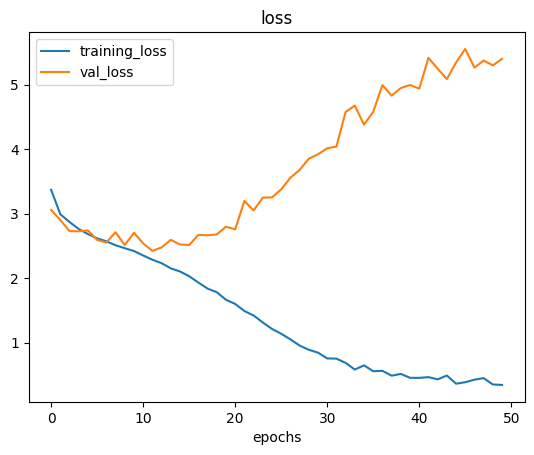

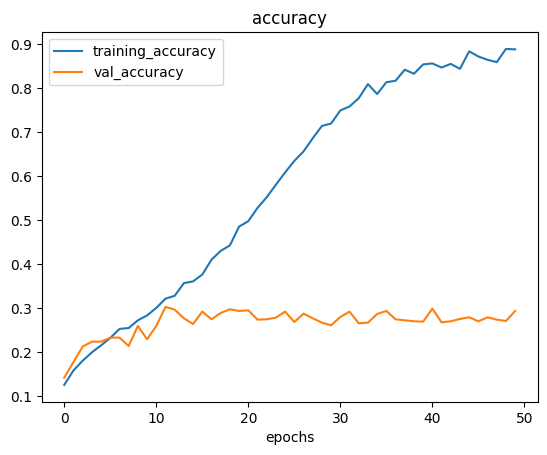

In [87]:
plot_loss_curves(history)

In [88]:
saved = tf.keras.models.load_model('/kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_1block_2080/cp-0023.keras')
saved.evaluate(batched_test, verbose=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 339ms/step - accuracy: 0.2938 - loss: 2.5816


[2.5965936183929443, 0.28856825828552246]

In [89]:
predictions = saved.predict(batched_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 290ms/step


In [90]:
y = np.concatenate([y for _, y in batched_test], axis=0)

In [91]:
y.shape

(1802, 28)

In [92]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

In [93]:
def calculate_metrics(y_true, y_pred):
  """
  Calculates precision, recall, and F1-score for all classes.

  Args:
      y_true (array-like): True labels for each data point.
      y_pred (array-like): Predicted labels for each data point.

  Returns:
      pd.DataFrame: A pandas DataFrame containing precision, recall, F1-score, and support for each class.
  """

  # Get metrics per class
  precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

  # Create column names
  column_names = ["Precision", "Recall", "F1-score", "Support"]

  # Create a DataFrame with class names as index
  class_names = ["Class " + str(i) for i in range(len(precision))]  # Or use class names from your dataset
  df = pd.DataFrame(list(zip(precision, recall, f1, support)), columns=column_names, index=class_names)

  return df

In [94]:
metrics_df = calculate_metrics(
    np.argmax(y, axis=1),
    np.argmax(predictions, axis=1)
)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
metrics_df

,Precision,Recall,F1-score,Support
Class 0,0.075472,0.136364,0.097166,88
Class 1,0.000000,0.000000,0.000000,17
Class 2,0.000000,0.000000,0.000000,3
Class 3,0.041667,0.017857,0.025000,56
Class 4,0.033058,0.053333,0.040816,75
Class 5,0.029412,0.035714,0.032258,28
Class 6,0.050000,0.062500,0.055556,112
Class 7,0.059524,0.050000,0.054348,100
Class 8,0.045455,0.030303,0.036364,66
Class 9,0.065217,0.081081,0.072289,37


# TWO BRANCH

In [96]:
model = EfficientNetV2B0(
    l_input_shape=(128, 128, 1),
    ab_input_shape=(128, 128, 2),
    l_ratio=0.2,
    depth_coefficient=0.5,
    width_coefficient=0.5,
    num_blocks_to_branch=2,
    classes=28
)

model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)

In [97]:
checkpoint_path = "/kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_2block_2080/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

In [98]:
history = model.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=50,
    callbacks=[checkpoint_callback]
)

Epoch 1/50
      5/Unknown 57s 30ms/step - accuracy: 0.0301 - loss: 4.3847

W0000 00:00:1719037069.446621     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


    178/Unknown 60s 19ms/step - accuracy: 0.0965 - loss: 3.6614

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1719037076.854139     165 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.15770, saving model to /kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_2block_2080/cp-0001.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 67s 59ms/step - accuracy: 0.0969 - loss: 3.6561 - val_accuracy: 0.1577 - val_loss: 3.0144
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1545 - loss: 3.0024
Epoch 2: val_accuracy did not improve from 0.15770
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.1546 - loss: 3.0021 - val_accuracy: 0.1501 - val_loss: 3.2651
Epoch 3/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1707 - loss: 2.8887
Epoch 3: val_accuracy improved from 0.15770 to 0.19864, saving model to /kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_2block_2080/cp-0003.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.1709 - loss: 2.8880 - val_accuracy: 0.1986 - val_loss: 2.7046
Epoch 4/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2092 - loss: 2.7268
Epoch 4: val_accuracy

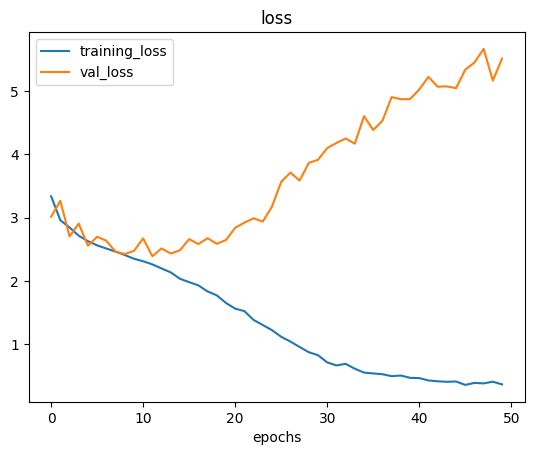

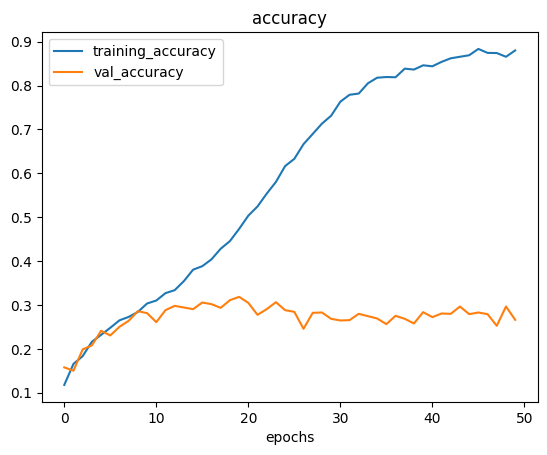

In [99]:
plot_loss_curves(history)

In [101]:
saved = tf.keras.models.load_model('/kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_2block_2080/cp-0020.keras')
saved.evaluate(batched_test, verbose=1)

      1/Unknown 22s 22s/step - accuracy: 0.1875 - loss: 2.8845

W0000 00:00:1719037316.209237     164 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 320ms/step - accuracy: 0.3139 - loss: 2.7117


W0000 00:00:1719037334.120983     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[2.7179949283599854, 0.3091009855270386]

# THREE BRANCH

In [102]:
model = EfficientNetV2B0(
    l_input_shape=(128, 128, 1),
    ab_input_shape=(128, 128, 2),
    l_ratio=0.2,
    depth_coefficient=0.5,
    width_coefficient=0.5,
    num_blocks_to_branch=3,
    classes=28
)

model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)

In [103]:
checkpoint_path = "/kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_3block_2080/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

In [104]:
history = model.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=50,
    callbacks=[checkpoint_callback]
)

Epoch 1/50
      5/Unknown 53s 30ms/step - accuracy: 0.0624 - loss: 4.4475  

W0000 00:00:1719037408.678914     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


    179/Unknown 56s 19ms/step - accuracy: 0.0936 - loss: 3.8047

W0000 00:00:1719037415.728074     164 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.15694, saving model to /kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_3block_2080/cp-0001.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 62s 55ms/step - accuracy: 0.0938 - loss: 3.8008 - val_accuracy: 0.1569 - val_loss: 2.9852
Epoch 2/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1552 - loss: 3.0508
Epoch 2: val_accuracy improved from 0.15694 to 0.17741, saving model to /kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_3block_2080/cp-0002.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.1552 - loss: 3.0503 - val_accuracy: 0.1774 - val_loss: 2.8752
Epoch 3/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1854 - loss: 2.8749
Epoch 3: val_accuracy improved from 0.17741 to 0.20849, saving model to /kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_3block_2080/cp-0003.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.1855 - loss: 2.8746 - val_accuracy: 0.2085 - val_loss: 2.8169
Ep

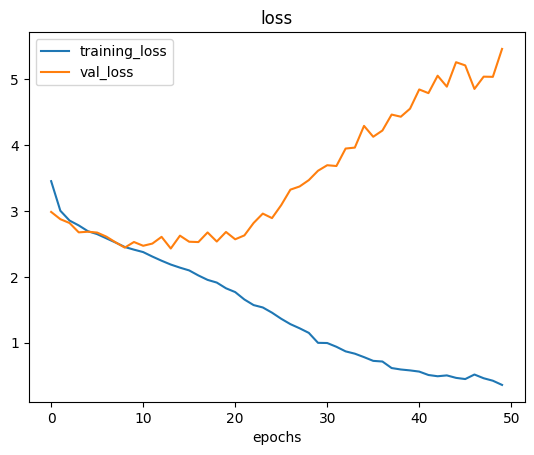

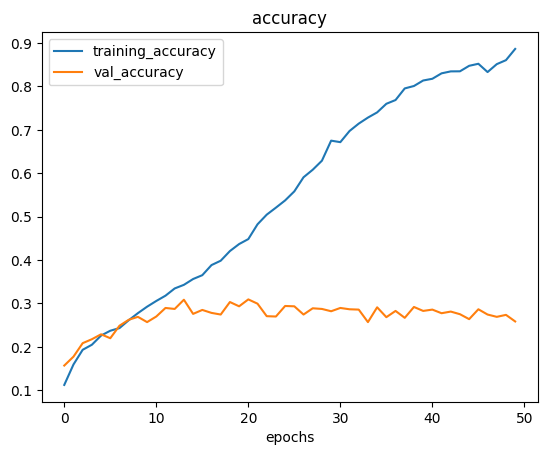

In [105]:
plot_loss_curves(history)

In [106]:
saved = tf.keras.models.load_model('/kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_3block_2080/cp-0021.keras')
saved.evaluate(batched_test, verbose=1)

      1/Unknown 24s 24s/step - accuracy: 0.2500 - loss: 2.6487

W0000 00:00:1719037674.605966     164 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 275ms/step - accuracy: 0.2901 - loss: 2.6642


W0000 00:00:1719037689.953825     166 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[2.6257479190826416, 0.30133184790611267]

# FOUR BRANCH

In [107]:
model = EfficientNetV2B0(
    l_input_shape=(128, 128, 1),
    ab_input_shape=(128, 128, 2),
    l_ratio=0.2,
    depth_coefficient=0.5,
    width_coefficient=0.5,
    num_blocks_to_branch=4,
    classes=28
)

model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)

In [108]:
checkpoint_path = "/kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_4block_2080/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

In [109]:
history = model.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=50,
    callbacks=[checkpoint_callback]
)

Epoch 1/50
      5/Unknown 67s 30ms/step - accuracy: 0.0477 - loss: 4.1739

W0000 00:00:1719037796.183523     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


    180/Unknown 70s 19ms/step - accuracy: 0.0960 - loss: 3.7185

W0000 00:00:1719037804.340533     166 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.14405, saving model to /kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_4block_2080/cp-0001.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 79s 69ms/step - accuracy: 0.0961 - loss: 3.7167 - val_accuracy: 0.1440 - val_loss: 2.9987
Epoch 2/50
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1507 - loss: 3.0102
Epoch 2: val_accuracy improved from 0.14405 to 0.20243, saving model to /kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_4block_2080/cp-0002.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1509 - loss: 3.0097 - val_accuracy: 0.2024 - val_loss: 2.8503
Epoch 3/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1881 - loss: 2.8708
Epoch 3: val_accuracy did not improve from 0.20243
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.1882 - loss: 2.8705 - val_accuracy: 0.1774 - val_loss: 2.8351
Epoch 4/50
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1990 - loss: 2.7753
Epoch 4: val_accuracy

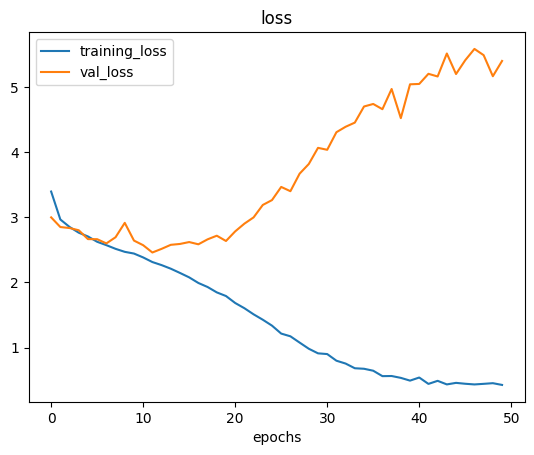

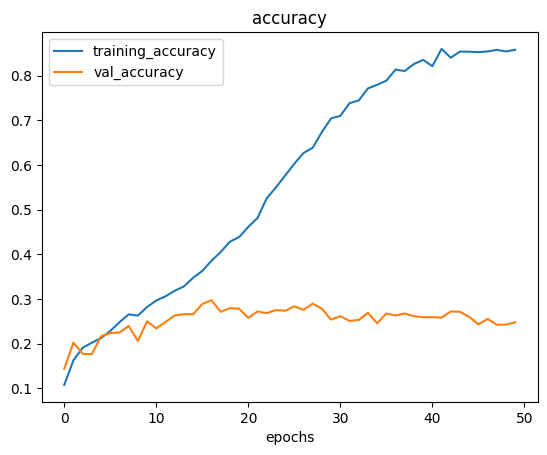

In [110]:
plot_loss_curves(history)

In [111]:
saved = tf.keras.models.load_model('/kaggle/working/plantdoc/two_branch_efficientnetv2b0custom_4block_2080/cp-0017.keras')
saved.evaluate(batched_test, verbose=1)

      1/Unknown 25s 25s/step - accuracy: 0.2500 - loss: 2.4304

W0000 00:00:1719038196.525389     165 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 309ms/step - accuracy: 0.3053 - loss: 2.5132


W0000 00:00:1719038213.827099     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[2.544328451156616, 0.3002219796180725]